# PUI2017 HW9

__This notebook is designed to pratice with both geopandas and census data.  This is a simple spatial exploratory analysis of census data. The goal is to assess wheather the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.__

__THE CENSUS__: The 1 year survey data is what we will use: https://www.census.gov/services/index.html


# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will lead to an estimate (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

PUMAs were first created for the 1990 Census. PUMAs are identified by a specific 4 numbers id. In the shapefile foung at data.cityofnewyork.us the id is named "puma" and it is in fact a 4 digits number. You can read it in as an integer (although of course it is a categorical variable inherently!). Often the PUMA id is found in conjunction with the 3 numbers state id, leading to a 7 numbers identification. The id for the State of NY is 036. See this link for more: https://www.census.gov/geo/reference/geoidentifiers.html


In [88]:
import urllib
import geopandas as gpd
import os
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")
import pylab as pl
%pylab inline
import shapely
import requests
import json
import pandas as pd
try:
    #for Python 2
    from StringIO import StringIO 
except ImportError:
    #for Python 3
    from io import StringIO
from fiona.crs import from_epsg
import pysal as ps
import choroplethNYC as cp

Populating the interactive namespace from numpy and matplotlib


In [89]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"

In [90]:
urllib.request.urlretrieve(url, "file.gz")
os.system("curl -O url")
os.system("mv file.gz " + os.getenv("PUIDATA"))
os.system("unzip "+ os.getenv("PUIDATA") + "/file.gz -d " + os.getenv("PUIDATA"))

0

In [91]:
filename = ! ls $PUIDATA/geo*.shp
filename = filename[0]

In [92]:
pumashp=gpd.GeoDataFrame.from_file(filename)

In [93]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [94]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2  Plot the PUMA NYC regions

First I plot with the geopandas build in function, and then with Prof. Federica Bianco's function cp.choroplethNYC

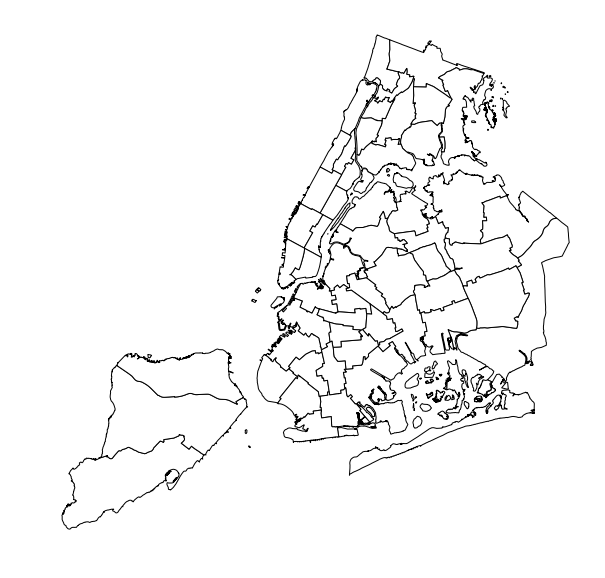

In [95]:
#testing the geopandas' built in function
fig, ax = pl.subplots(figsize=(10, 10))
axis("off")
pumashp.plot(ax=ax, color='white', edgecolor='black');

__Figure 1__ : Map of New York City divideded by PUMAs. Plotted using geoPandas built-in plot function.

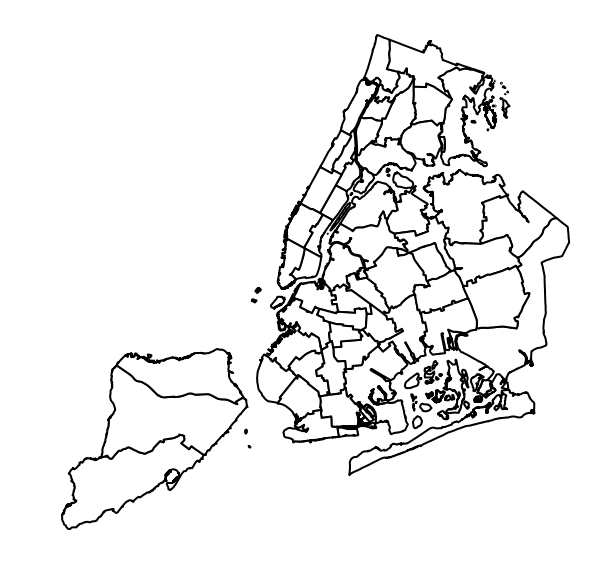

In [96]:
# using a choroplethNYC function that FBB wrote
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

__Figure 2__ : Map of New York City divideded by PUMAs. Plotted using cloroplethNYC function written by Federica Bianco.

# 2. American Fact Finder data on percentage of houses with broadband internet access

Download the table of data from 2016 for NYC: you want to obtain data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

You  should read the datta in thgouth the API but also download the data manually and compare the two datasets.

## 2.1 Get data with American Fact Finder (AFF) API:

To run this notebook, request an API key at https://www.census.gov/developers/ , and then save it on a censusAPI.py file as #myAPI = 'XXXXXXXXXXXXXXX'

In [97]:
#reading in my api key saved in censusAPI.py as
from censusAPI import myAPI

If you need help with the API you can ask questions in this [Gitter channel](https://gitter.im/uscensusbureau/general) 
The internet subscription by household is data surveyd annually. You can find out what are the features that you can query through the API for the annually surveyed data at this url: https://api.census.gov/data/2016/acs/acs1/variables.json

read it in as a json file - you can do it with pandas (but it is slow). You can do it as I do below with the request package.

In [98]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp =  requests.request('GET', url)
aff1y = json.loads(resp.text)

In [99]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

You need two features: **total number of households**, and **number of households with broadband access**

Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "\_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations  (rows that start with "B28002") that include the word "Broadband" in the description.

The syntax is a lost comprehension:

        as = \[a for a in listOfAs\] 

is simply a compact way to write

        as = \[\]
        for a in listOfAs:
            as.append(a)
            
with an if statement tha selects broadband         

In [100]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subs

chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the \_001 variable (B28002_001 in this case). "E" stands for *estimate*. M stands for *margin of error*, EA *estimate annotations*, MA *margin of error annotations*. You want the estimate for this exercise. 

In [101]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

Similarly, choose the fractions of houses with any "With an Internet subscription!!Broadband of any type"

In [102]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

Now that you have the variable names use them to extract the relevant data with the ACS API. 

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=\[variable Name\],NAME

geometry: for=\[geometry\]:\[desired geometry values\]in=\[larger geometry\]:\[desired larger geometry values\]

API key: key:\[api key\]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS

state:36 is New York State

In [103]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [104]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [105]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [106]:
pumaBB.columns

Index(['B28002_004E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4'],
      dtype='object')

In [107]:
pumaBB.drop(["Unnamed: 4"],axis=1,inplace=True)
pumaPP.drop(["Unnamed: 4"],axis=1,inplace=True)

In [108]:
pumaBB=pd.merge(pumaBB,pumaPP,on = ["NAME","state","public use microdata area"])
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [109]:
pumaBB["pcBB"] = (pumaBB["B28002_004E"] / pumaBB["B28002_001E"]) * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all 

    - Topics: Product Type -> Geography Comparison Table  
    
select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION  at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.
    
Your table shold be labeled as: GCT2801	

## BIANCA: I run on my local machine so did not use sftp


One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste!
Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

1. ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following *sftp* command
        
        fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu
    
2. Input your password
            
        Password: 
        Connected to staging.cusp.nyu.edu.

   This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)
    
        sftp> cd /home/fbianco/PUIdata             
        
3. Use the sftp command _put_ to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)
    
        sftp> put /Users/fbianco/Downloads/aff_download.zip
        
You should see:

            Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need

### I download the table .zip from the AFF website and placed it in PUI DATA. 
### My .zip file was called ACS_16_1YR_GCT2801.ST50.zip (should be the same)

In [110]:
##WEIRD AND HAD TO DOWLOAD MANUALLY HOW DO I DO IT REPRODUCIBLE???
os.system("unzip "+ os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50.zip -d " + os.getenv("PUIDATA"))

256

In [111]:
pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"]).head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6


notice 2 things:
    - The Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. We can subtract 360000 to obtain value without the  36 (New York State value) so that it can merge with puma id.  
    - that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.

In [112]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"], skiprows = [1,2])

type(bbpc["GCT_STUB.target-geo-id2"][0])

numpy.int64

In [113]:
bbpc.rename(columns = {"GCT_STUB.target-geo-id2" : "gid"}, inplace = True)
bbpc["gid"] = bbpc.gid - 3600000
bbpc.head()

,gid,HC01,HC02
0,100,80.6,2.6
1,200,75.7,2.2
2,300,79.8,2.6
3,401,81.4,2.4
4,402,78.2,2.3


## Check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [114]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


The maximum difference is only of a few percent -- OK.

# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [115]:
pumaBB.rename(columns = {"public use microdata area" : "puma"}, inplace = True)

In [116]:
pumashp["puma"] = pumashp.puma.astype(int)

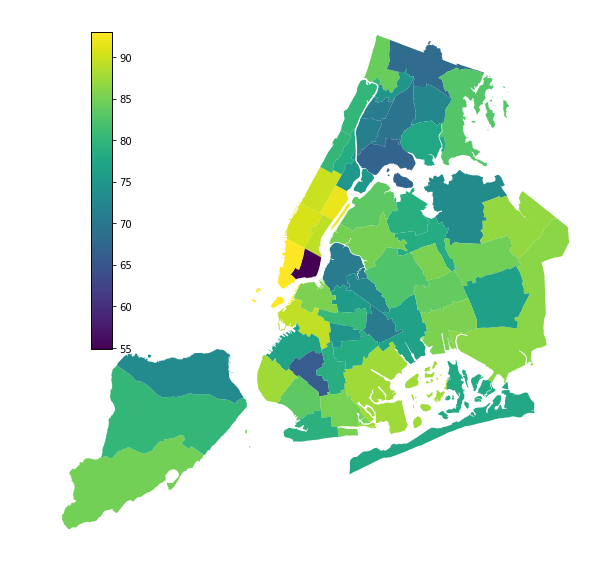

In [117]:
#choropleth of the percentage of internet axcess
pumashp = pumashp.merge(pumaBB)
cp.choroplethNYC(pumashp, column="pcBB");

__Figure 3__ : Percentage of households with broadband access in New York City by PUMA. 2016 Census Data

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe
read it in from the HW9_fb55 folder in :
https://github.com/fedhere/PUI2017_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [118]:
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv",index_col=0)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [119]:
linkNYC.shape

(1414, 4)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab.

In [120]:
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [121]:
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [122]:
linkNYC = gpd.GeoDataFrame(linkNYC)

In [123]:
linkNYC.crs = from_epsg(4326)

# Plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

I have also color coded the station by how long ago they have been installed, using the date datetime variable

In [124]:
linkNYC["date_link_"] = pd.to_datetime(linkNYC["date_link_"])
type(linkNYC.date_link_[0])

pandas._libs.tslib.Timestamp

/Users/biancabrusco/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


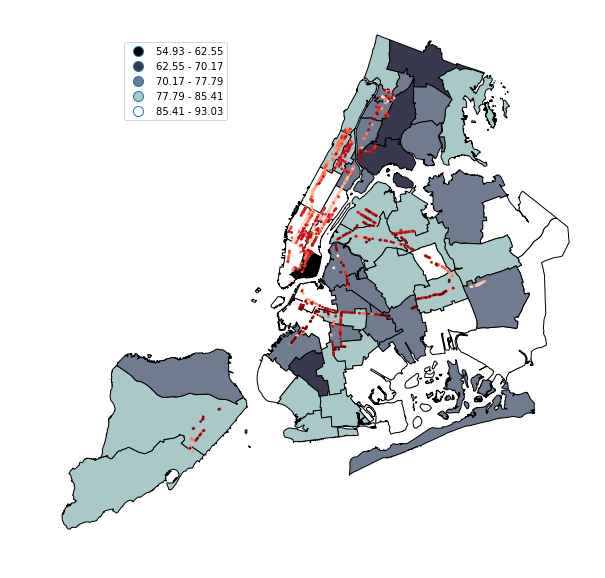

In [125]:
fig, ax = pl.subplots(figsize=(10, 10))
cp.choroplethNYC(pumashp, ax = ax, column="pcBB", scheme="Equal_interval", k=5, cmap = "bone", edgecolor = "black", lw = 1);
linkNYC.plot(ax = ax, marker = 'o', c = linkNYC.date_link_ , cmap = "Reds" ,markersize = 3);

__Figure 4__ : Location of linkNYC stations, overlayed on cloropleth of percentage of households with broadband, by PUMA. Data from 2016 Census. 

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [126]:
keyPOP = 'B00001_001E'
aff1y['variables'][keyPOP]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [127]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [128]:
pumaPop.columns

Index(['B00001_001E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4'],
      dtype='object')

In [129]:
pumaPop.drop("Unnamed: 4",axis=1,inplace=True)
pumaPop.rename(columns = {"public use microdata area" : "puma"},inplace=True)

In [130]:
pumaPop.head()

,B00001_001E,NAME,state,puma
0,3075,"St. Lawrence County PUMA, New York",36,100
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,2736,"Warren & Washington Counties PUMA, New York",36,300
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )


(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

In [131]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,69.425612


In [132]:
pumashp = pumashp.merge(pumaPop, on = ["NAME","state",'puma'])
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,B28002_001E,pcBB,B00001_001E
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,84.275820,1517
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,68.310015,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,82.826141,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,72.553737,1882
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,69.425612,2011


In [133]:
#convert coordinates for pumashp and linkNYC
pumashpFlat = pumashp.to_crs(epsg=2263)
linkNYCFlat = linkNYC.to_crs(epsg=2263)
print(pumashpFlat.crs)
print(linkNYCFlat.crs)

{'init': 'epsg:2263', 'no_defs': True}
{'init': 'epsg:2263', 'no_defs': True}


In [134]:
#create a geodataframe with a spatial join
linkNYCFlat.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045344363)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186805)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.900946364)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.157733508)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761382252)


In [135]:
#use groupby to count the number of linkNYC in each PUMA
linkpp = gpd.sjoin(pumashpFlat,linkNYCFlat).groupby(["puma"]).count()
linkpp = linkpp[['link_site']]
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have _all_ the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [136]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,B28002_001E,pcBB,B00001_001E
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,84.275820,1517
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,68.310015,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,82.826141,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,72.553737,1882
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,69.425612,2011


In [137]:
pumashplc = pd.merge(pumashp,linkpp, how="left", left_on=["puma"],right_index=True)
pumashplc.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,B28002_001E,pcBB,B00001_001E,link_site
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,84.275820,1517,1.0
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,68.310015,1959,NaN
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,82.826141,1305,NaN
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,72.553737,1882,NaN
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,69.425612,2011,1.0


In [138]:
pumashplc["linkNYCp100p"] = (pumashplc["link_site"]/(pumashplc.B00001_001E)*100)

In [139]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


/Users/biancabrusco/anaconda/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/biancabrusco/anaconda/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/biancabrusco/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/biancabrusco/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


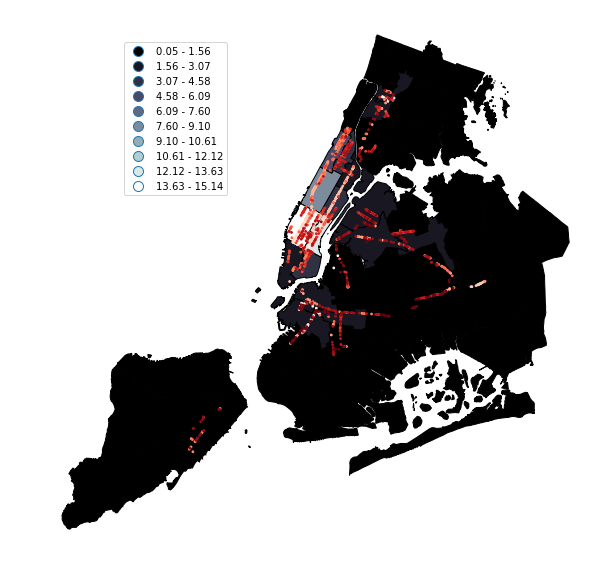

In [140]:
fig, ax = pl.subplots(figsize=(10, 10))
cp.choroplethNYC(pumashplc, ax = ax, column="linkNYCp100p", scheme="Equal_interval", k=10, cmap = "bone", edgecolor = "black", lw = 1);
linkNYC.plot(ax = ax, marker = 'o', c = linkNYC.date_link_ , cmap = "Reds" ,markersize = 3);

__Figure 5__ : Location of linkNYC stations, overlayed on cloropleth of number of stations per 100 people, by PUMA. Binning in 10 equal intervals. Data from 2016 Census. 

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

In [141]:
pumashplc.fillna(0,inplace=True)

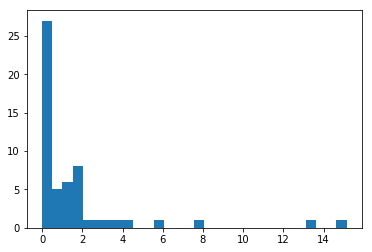

In [142]:
pl.hist(pumashplc["linkNYCp100p"], bins = 30);

We do not want to just remove the outliers because they are important part of the story. However, we can bin differently in the choloropleth. 

/Users/biancabrusco/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


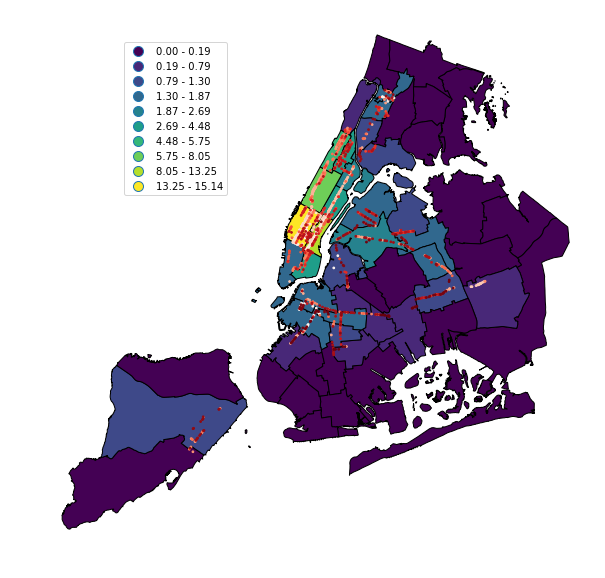

In [143]:
# to decide if want to use viridis or bone or something else.
fig, ax = pl.subplots(figsize=(10, 10))
cp.choroplethNYC(pumashplc, ax = ax, column="linkNYCp100p", scheme="fisher_jenks", cmap = "viridis", edgecolor = "black", lw = 1);
linkNYC.plot(ax = ax, marker = 'o', c = linkNYC.date_link_ , cmap = "Reds" ,markersize = 3);

__Figure 5__ : Location of linkNYC stations, overlayed on cloropleth of number of stations per 100 people, by PUMA. Binning by Fisher Jenks Scheme. Data from 2016 Census. 

From Wikipedia : 
https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
"This is done by seeking to minimize each class’s average deviation from the class mean, while maximizing each class’s deviation from the means of the other groups. In other words, the method seeks to reduce the variance within classes and maximize the variance between classes".

## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


In [144]:
#use pysal package

__Spatial Weights__

In [145]:
#with pysal package and the shapefile: assign weights
qw_puma = ps.queen_from_shapefile(filename)

__Matrix of Weights__

In [146]:
#create the matrix of the weights
Wmatrix, ids = qw_puma.full()
Wmatrix.shape

(55, 55)

In [147]:
qw_puma.transform = 'r'

__Spatial Lag__

In [148]:
pumashplc.tail()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,B28002_001E,pcBB,B00001_001E,link_site,linkNYCp100p
50,4110,71251.084697,2.050472e+08,POLYGON ((-73.89783236941891 40.73516035418231...,50844,"NYC-Queens Community District 5--Ridgewood, Gl...",36,61570,82.579178,3259,0.0,0.000000
51,4111,56323.013991,1.326035e+08,POLYGON ((-73.82009462642849 40.70957598523835...,37570,NYC-Queens Community District 9--Richmond Hill...,36,44811,83.841021,3124,40.0,1.280410
52,4112,72781.304161,2.600517e+08,POLYGON ((-73.75725671377032 40.71813860165978...,54603,"NYC-Queens Community District 12--Jamaica, Hol...",36,71109,76.787748,3940,18.0,0.456853
53,4113,110717.942782,1.714665e+08,(POLYGON ((-73.85722330984366 40.6502786705413...,32506,NYC-Queens Community District 10--Howard Beach...,36,37998,85.546608,2162,0.0,0.000000
54,4114,412606.741712,3.156828e+08,(POLYGON ((-73.83668274106707 40.5949466970158...,32172,NYC-Queens Community District 14--Far Rockaway...,36,41368,77.770257,1559,0.0,0.000000


**To lag impact I use the linkNYC per 100 person column and divided by number of people ( to get linkNYC per person) and then divide it by percentage of people NOT having broadban** 

In [149]:
#impact: linkNYC per person over percentage of broadband household access
pumashplc["linkNYCpp"] = pumashplc.linkNYCp100p/pumashplc.B00001_001E/(1-pumashplc.pcBB)

In [150]:
linkNYCpp = pumashplc.linkNYCpp  #select column of interest
linkNYCppLag = ps.lag_spatial(qw_puma, linkNYCpp)

__Create Quantiles for mapping__ 

In [156]:
## here i create lag deciles -- using ps.Quantiles and specifying i want 10
#intervals. see below the deviles division.
linkNYCppLagQ10 = ps.Quantiles(linkNYCppLag, k = 10)
linkNYCppLagQ10

               Quantiles               
 
Lower            Upper            Count
         x[i] <= -0.000               6
-0.000 < x[i] <= -0.000               5
-0.000 < x[i] <= -0.000               6
-0.000 < x[i] <= -0.000               5
-0.000 < x[i] <= -0.000               6
-0.000 < x[i] <= -0.000               5
-0.000 < x[i] <= -0.000               5
-0.000 < x[i] <= -0.000               6
-0.000 < x[i] <= -0.000               5
-0.000 < x[i] <=  0.000               6

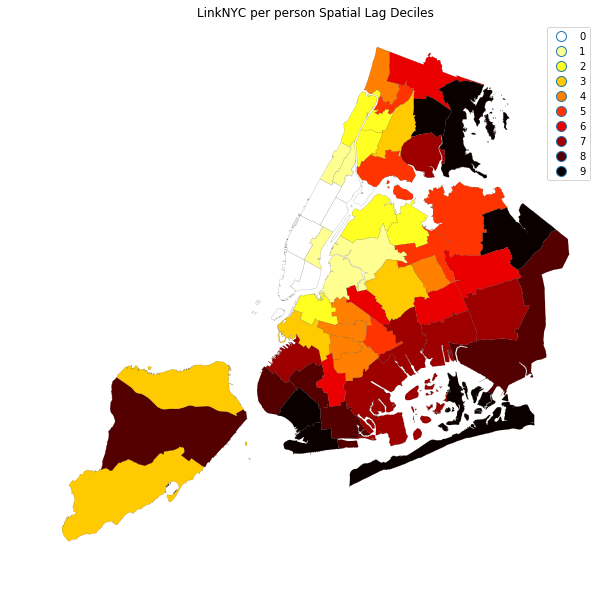

In [157]:
fig, ax = pl.subplots(figsize = (10,10))
pumashplc.assign(cl = linkNYCppLagQ10.yb).plot(column = "cl", categorical = True, k=5,
                                              cmap = "hot_r", edgecolor="black",
                                            linewidth = 0.1, ax = ax, legend =True)
ax.set_axis_off()
pl.title("LinkNYC per person Spatial Lag Deciles")

__Figure 6__ : Spatial Lag Deciles for number of LinkNYC per person by Puma. 

## ----- end  
Note: To find the table you extracted through the API manually you could

https://factfinder.census.gov/ -> Advanced Search -> Show me all 
    
    - Topics: Housing -> Physical Characteristics -> Internet Access
    - Geographies -> all geography types -> Public Use Microdata Areas (755)
                     -> Select a State: New York -> All Pubic Use Microdaa Areas within New York
                     -> Add Your Selection
    - Years -> 2016